In [ ]:
#!/usr/bin/env python3
"""
Evaluation & Interpretation — Reproducible Pipeline (FAST OPTION, Jupyter-safe)

Builds the binary target "above-median fossil-share reduction from baseline (2000) to outcome (2019)"
and evaluates models with cross-validation and hyperparameter search.

Outputs:
- metrics_summary.csv      ROC-AUC, Accuracy, F1 for each model
- best_params.json         Best hyperparameters per model
- feature_importances.csv  If best model exposes feature_importances_

Speed-ups when --fast is enabled:
- CV folds = 3 (vs 5)
- Smaller grids / RandomizedSearchCV
- Skips XGBoost/LightGBM by default
- Caches preprocessing to avoid recomputation across folds

Works in notebooks and scripts (ignores Jupyter’s extra CLI args).

"""

'\nEvaluation & Interpretation — Reproducible Pipeline (FAST OPTION, Jupyter-safe)\n\nBuilds the binary target "above-median fossil-share reduction from baseline (2000) to outcome (2019)"\nand evaluates models with cross-validation and hyperparameter search.\n\nOutputs:\n- metrics_summary.csv      ROC-AUC, Accuracy, F1 for each model\n- best_params.json         Best hyperparameters per model\n- feature_importances.csv  If best model exposes feature_importances_\n\nSpeed-ups when --fast is enabled:\n- CV folds = 3 (vs 5)\n- Smaller grids / RandomizedSearchCV\n- Skips XGBoost/LightGBM by default\n- Caches preprocessing to avoid recomputation across folds\n\nWorks in notebooks and scripts (ignores Jupyter’s extra CLI args).\n\n'

In [24]:
import argparse, json, os, re, sys, warnings, shutil
from typing import List, Tuple
import numpy as np, pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from joblib import Memory
from tempfile import mkdtemp

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)

In [25]:
# Optional models: only used if installed AND not disabled
try:
    from xgboost import XGBClassifier  # type: ignore
    HAS_XGB = True
except Exception:
    HAS_XGB = False
try:
    from lightgbm import LGBMClassifier  # type: ignore
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

SEED = 42
np.random.seed(SEED)

In [26]:
# ---------- Utilities ----------
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = [re.sub(r'[^0-9a-zA-Z_]+','_', c.strip().lower()).strip('_') for c in df.columns]
    seen, new_cols = {}, []
    for c in cols:
        if c not in seen:
            seen[c] = 1
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}_{seen[c]}")
    out = df.copy(); out.columns = new_cols
    return out

In [27]:
def guess_column(df: pd.DataFrame, candidates: List[str], contains_all: List[str] = None) -> str:
    contains_all = contains_all or []
    for name in candidates:
        n = re.sub(r'[^0-9a-zA-Z_]+','_', name.strip().lower()).strip('_')
        if n in df.columns: return n
    for c in df.columns:
        if all(sub in c for sub in contains_all): return c
    raise ValueError(f"Could not infer column from candidates={candidates} / contains={contains_all}")

In [28]:
def ensure_fossil_share(df: pd.DataFrame, fossil_share_col: str = None) -> Tuple[pd.DataFrame, str]:
    if fossil_share_col and fossil_share_col in df.columns:
        return df, fossil_share_col
    possible = [c for c in df.columns if 'fossil' in c and 'share' in c]
    if possible: return df, possible[0]
    fossil_candidates = [c for c in df.columns if 'fossil' in c and ('energy' in c or 'consumption' in c or 'use' in c or c.endswith('fossil'))]
    total_candidates  = [c for c in df.columns if 'total' in c and ('energy' in c or 'consumption' in c or 'use' in c or c.endswith('total'))]
    if fossil_candidates and total_candidates:
        fcol, tcol = fossil_candidates[0], total_candidates[0]
        out_col = 'fossil_share'
        df = df.copy(); df[out_col] = np.where(df[tcol] != 0, df[fcol] / df[tcol], np.nan)
        return df, out_col
    raise ValueError("Could not find or compute a fossil_share column. Provide --fossil_share_col or include fossil/total columns.")


In [29]:
def build_label(df: pd.DataFrame, id_col: str, year_col: str, fossil_share_col: str,
                baseline_year: int, outcome_year: int) -> pd.DataFrame:
    grp = df.groupby([id_col, year_col], as_index=False).mean(numeric_only=True)
    base = grp.loc[grp[year_col]==baseline_year, [id_col, fossil_share_col]].rename(columns={fossil_share_col:'fossil_share_baseline'})
    outc = grp.loc[grp[year_col]==outcome_year, [id_col, fossil_share_col]].rename(columns={fossil_share_col:'fossil_share_outcome'})
    merged = pd.merge(base, outc, on=id_col, how='inner')
    merged['reduction'] = merged['fossil_share_baseline'] - merged['fossil_share_outcome']
    national_median = merged['reduction'].median()
    merged['label'] = (merged['reduction'] > national_median).astype(int)
    return merged

In [30]:
def prepare_features(df: pd.DataFrame, id_col: str, year_col: str, baseline_year: int, drop_cols: List[str]) -> pd.DataFrame:
    base = df.loc[df[year_col]==baseline_year].copy()
    num_cols = base.select_dtypes(include=np.number).columns.tolist()
    cat_cols = [c for c in base.columns if c not in num_cols]
    agg = {**{c:'mean' for c in num_cols}, **{c:'first' for c in cat_cols}}
    base = base.groupby(id_col, as_index=False).agg(agg)
    safe_drop = [c for c in drop_cols if c != id_col]
    base = base.drop(columns=[c for c in safe_drop if c in base.columns], errors='ignore')
    return base

In [31]:
def build_preprocessor(numeric_cols: List[str], categorical_cols: List[str]) -> ColumnTransformer:
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=0.01)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore')
    return ColumnTransformer([
        ('num', StandardScaler(with_mean=True, with_std=True), numeric_cols),
        ('cat', ohe, categorical_cols),
    ])

In [32]:
def get_feature_names_from_preprocessor(preprocessor: ColumnTransformer, numeric_cols: List[str], categorical_cols: List[str]) -> List[str]:
    num_features = list(numeric_cols)
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_features = cat_transformer.get_feature_names_out(categorical_cols).tolist() if hasattr(cat_transformer, 'get_feature_names_out') else list(categorical_cols)
    return num_features + cat_features


In [33]:
def _auto_csv_path(p: str) -> str:
    candidates = [p, "./df_merged.csv", "/df_merged.csv", "/mnt/data/df_merged.csv", os.path.join(os.getcwd(), "df_merged.csv")]
    tried = []
    for c in candidates:
        if c and c not in tried:
            tried.append(c)
            if os.path.exists(c):
                return c
    raise SystemExit("CSV not found. Tried: " + ", ".join(tried))

In [45]:
# ---------- Training ----------
def train_and_evaluate(X: pd.DataFrame, y: pd.Series, numeric_cols: List[str], categorical_cols: List[str],
                       seed: int, fast: bool, use_xgb: bool, use_lgbm: bool, cache_dir: str):
    cv = StratifiedKFold(n_splits=(3 if fast else 5), shuffle=True, random_state=seed)
    preproc = build_preprocessor(numeric_cols, categorical_cols)
    memory = Memory(location=cache_dir, verbose=0)

    models = []  # each item: dict(name, estimator, params, mode('grid'|'random'), n_iter)

    # Logistic Regression
    if fast:
        lr = LogisticRegression(max_iter=2000, random_state=seed, solver='liblinear')
        lr_grid = {'model__penalty': ['l2'], 'model__C': [0.1, 1, 10]}
        models.append({'name':'LogisticRegression', 'estimator': lr, 'params': lr_grid, 'mode':'grid'})
    else:
        lr = LogisticRegression(max_iter=5000, random_state=seed, solver='saga')
        lr_grid = {'model__penalty':['l1','l2','elasticnet'], 'model__C':[0.01,0.1,1,10,100], 'model__l1_ratio':[0,.25,.5,.75]}
        models.append({'name':'LogisticRegression', 'estimator': lr, 'params': lr_grid, 'mode':'grid'})
        # Random Forest
    if fast:
        rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
        rf_dist = {'model__n_estimators':[150,300], 'model__max_depth':[None,8,16], 'model__min_samples_leaf':[1,2,4],
                   'model__max_features':['sqrt',0.5], 'model__class_weight':[None,'balanced']}
        models.append({'name':'RandomForest', 'estimator': rf, 'params': rf_dist, 'mode':'random', 'n_iter':12})
    else:
        rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
        rf_grid = {'model__n_estimators':[200,400,800], 'model__max_depth':[None,5,10,20], 'model__min_samples_leaf':[1,2,4],
                   'model__max_features':['sqrt','log2',0.5], 'model__class_weight':[None,'balanced']}
        models.append({'name':'RandomForest', 'estimator': rf, 'params': rf_grid, 'mode':'grid'})

    # Gradient Boosting
    if fast:
        gb = GradientBoostingClassifier(random_state=seed)
        gb_dist = {'model__learning_rate':[0.03,0.1], 'model__n_estimators':[150,300], 'model__max_depth':[2,3], 'model__subsample':[0.8,1.0]}
        models.append({'name':'GradientBoosting', 'estimator': gb, 'params': gb_dist, 'mode':'random', 'n_iter':10})
    else:
        gb = GradientBoostingClassifier(random_state=seed)
        gb_grid = {'model__learning_rate':[0.01,0.05,0.1], 'model__n_estimators':[200,400,800], 'model__max_depth':[2,3,4], 'model__subsample':[0.6,0.8,1.0]}
        models.append({'name':'GradientBoosting', 'estimator': gb, 'params': gb_grid, 'mode':'grid'})

    # Optional: XGBoost / LightGBM (only when not fast and explicitly enabled)
    if not fast and use_xgb and HAS_XGB:
        xgb = XGBClassifier(random_state=seed, objective='binary:logistic', eval_metric='logloss', tree_method='hist', n_jobs=-1)
        xgb_grid = {'model__n_estimators':[300,600,1000], 'model__max_depth':[3,5,7], 'model__learning_rate':[0.03,0.1],
                    'model__subsample':[0.6,0.8,1.0], 'model__colsample_bytree':[0.6,0.8,1.0], 'model__reg_lambda':[1,5,10],
                    'model__min_child_weight':[1,3,5]}
        models.append({'name':'XGBoost', 'estimator': xgb, 'params': xgb_grid, 'mode':'grid'})
    if not fast and use_lgbm and HAS_LGBM:
        lgbm = LGBMClassifier(random_state=seed, verbose=-1)
        lgbm_grid = {'model__n_estimators':[300,600,1000], 'model__num_leaves':[15,31,63], 'model__max_depth':[-1,5,10],
                     'model__learning_rate':[0.03,0.1], 'model__feature_fraction':[0.6,0.8,1.0], 'model__bagging_fraction':[0.6,0.8,1.0],
                     'model__min_data_in_leaf':[10,20,40]}
        models.append({'name':'LightGBM', 'estimator': lgbm, 'params': lgbm_grid, 'mode':'grid'})

    rows, best_params = [], {}
    best_name, best_estimator, best_auc = None, None, -1.0

    for m in models:
        pipe = Pipeline(steps=[('preprocess', preproc), ('model', m['estimator'])], memory=memory)
        if m['mode'] == 'random':
            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=m['params'],
                n_iter=m.get('n_iter', 12),
                scoring='roc_auc',
                cv=cv,
                n_jobs=-1,
                refit=True,
                verbose=0,
                random_state=SEED
            )
        else:  # 'grid'
            search = GridSearchCV(
                estimator=pipe,
                param_grid=m['params'],
                scoring='roc_auc',
                cv=cv,
                n_jobs=-1,
                refit=True,
                verbose=0
            )

        search.fit(X, y)
        best_params[m['name']] = search.best_params_
        best_pipe = search.best_estimator_

        y_proba = cross_val_predict(best_pipe, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        auc_val = roc_auc_score(y, y_proba)
        acc_val = accuracy_score(y, y_pred)
        f1_val  = f1_score(y, y_pred)

        #MB Plot ROC curves
        fpr, tpr, _ = roc_curve(y, cross_val_predict(best_pipe, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{m['name']} (AUC = {roc_auc:.4f})')

        rows.append({'Model': m['name'], 'ROC_AUC': round(float(auc_val),4),
                     'Accuracy': round(float(acc_val),4), 'F1': round(float(f1_val),4)})

        if auc_val > best_auc:
            best_auc, best_name, best_estimator = auc_val, m['name'], best_pipe

    metrics_df = pd.DataFrame(rows).sort_values(by='ROC_AUC', ascending=False).reset_index(drop=True)
    shutil.rmtree(cache_dir, ignore_errors=True)  # free space
    return metrics_df, best_params, best_name, best_estimator

In [41]:
# ---------- Public API ----------
def run_pipeline(csv: str = "./df_merged.csv",
                 id_col: str = "state",
                 year_col: str = "year",
                 fossil_share_col: str = None,
                 baseline_year: int = 2000,
                 outcome_year: int = 2019,
                 include_baseline_target: bool = False,
                 seed: int = SEED,
                 save_dir: str = ".",
                 fast: bool = True,
                 use_xgb: bool = False,
                 use_lgbm: bool = False):
    if not os.path.exists(csv):
        csv = _auto_csv_path(csv)

    df_raw = pd.read_csv(csv)
    #MB remove fossil_share_2019 and Y_OUTCOME
    df_raw_2 = df_raw.iloc[:, :-2]
    df = normalize_columns(df_raw_2)

    id_col_res = id_col if id_col in df.columns else guess_column(df, [id_col], contains_all=['state'])
    year_col_res = year_col if year_col in df.columns else guess_column(df, [year_col], contains_all=['year'])
    df, fossil_share_col_res = ensure_fossil_share(df, fossil_share_col)

    labels_df = build_label(df, id_col_res, year_col_res, fossil_share_col_res, baseline_year, outcome_year)

    drop_cols = [year_col_res] + ([] if include_baseline_target else [fossil_share_col_res])
    features_df = prepare_features(df, id_col_res, year_col_res, baseline_year, drop_cols=drop_cols)

    data = pd.merge(features_df, labels_df[[id_col_res, 'label']], on=id_col_res, how='inner')
    if data['label'].nunique() < 2:
        raise RuntimeError("Label has <2 classes after merge. Check your years or input data.")

    y = data['label'].astype(int)
    X = data.drop(columns=['label'])

    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    cache_dir = mkdtemp(prefix="sk_cache_")
    metrics_df, best_params, best_name, best_estimator = train_and_evaluate(
        X, y, numeric_cols, categorical_cols, seed=seed,
        fast=fast, use_xgb=use_xgb, use_lgbm=use_lgbm, cache_dir=cache_dir
    )

    os.makedirs(save_dir, exist_ok=True)
    metrics_path = os.path.join(save_dir, 'metrics_summary.csv')
    params_path = os.path.join(save_dir, 'best_params.json')
    metrics_df.to_csv(metrics_path, index=False)
    with open(params_path, 'w') as f:
        json.dump(best_params, f, indent=2)

    fi_note = ""
    try:
        model = best_estimator.named_steps['model']
        pre = best_estimator.named_steps['preprocess']
        if hasattr(model, 'feature_importances_'):
            feat_names = get_feature_names_from_preprocessor(pre, numeric_cols, categorical_cols)
            importances = model.feature_importances_
            order = np.argsort(importances)[::-1]
            out_df = pd.DataFrame({'feature': [feat_names[i] for i in order],
                                   'importance': importances[order]})
            fi_path = os.path.join(save_dir, 'feature_importances.csv')
            out_df.to_csv(fi_path, index=False)
            fi_note = f"Feature importances saved to: {os.path.abspath(fi_path)}"
        else:
            fi_note = "(best model has no feature_importances_)"
    except Exception as e:
        fi_note = f"(could not compute feature importances: {e})"

    print("\n===== Evaluation Summary (CV) =====")
    print(metrics_df.to_string(index=False))
    print("\nBest model:", best_name)
    print("\nBest params per model:\n", json.dumps(best_params, indent=2))
    print("\nFiles saved:")
    print(" -", os.path.abspath(metrics_path))
    print(" -", os.path.abspath(params_path))
    print(" -", fi_note)
    return metrics_df, best_params, best_name

[info] Ignoring unknown args (likely from Jupyter/Colab): ['-f', '/root/.local/share/jupyter/runtime/kernel-b5140484-25fc-4079-b3de-aa43a00b046a.json']

===== Evaluation Summary (CV) =====
             Model  ROC_AUC  Accuracy     F1
      RandomForest   0.6336      0.66 0.6909
  GradientBoosting   0.6032      0.58 0.6316
LogisticRegression   0.5984      0.64 0.6250

Best model: RandomForest

Best params per model:
 {
  "LogisticRegression": {
    "model__C": 0.1,
    "model__penalty": "l2"
  },
  "RandomForest": {
    "model__n_estimators": 150,
    "model__min_samples_leaf": 4,
    "model__max_features": 0.5,
    "model__max_depth": null,
    "model__class_weight": null
  },
  "GradientBoosting": {
    "model__subsample": 1.0,
    "model__n_estimators": 150,
    "model__max_depth": 2,
    "model__learning_rate": 0.1
  }
}

Files saved:
 - /content/metrics_summary.csv
 - /content/best_params.json
 - Feature importances saved to: /content/feature_importances.csv


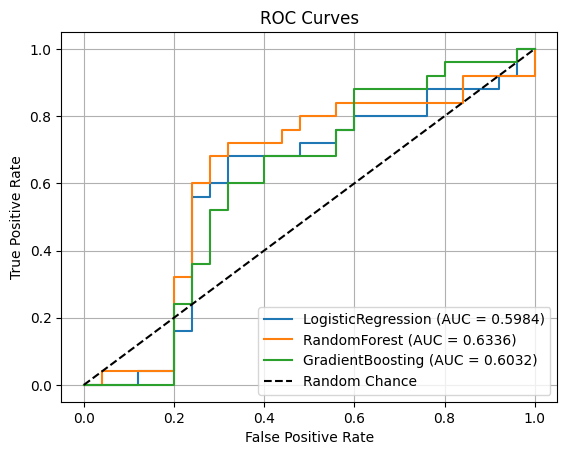

In [48]:
# ---------- CLI (Jupyter-safe) ----------
def cli_main(argv=None):
    parser = argparse.ArgumentParser(description="Evaluation & Interpretation — model selection pipeline (fast option)")
    parser.add_argument('--csv', type=str, default=os.environ.get('CSV', './df_merged.csv'))
    parser.add_argument('--id_col', type=str, default=os.environ.get('ID_COL', 'state'))
    parser.add_argument('--year_col', type=str, default=os.environ.get('YEAR_COL', 'year'))
    parser.add_argument('--fossil_share_col', type=str, default=os.environ.get('FOSSIL_SHARE_COL', None))
    parser.add_argument('--baseline_year', type=int, default=int(os.environ.get('BASELINE_YEAR', 2000)))
    parser.add_argument('--outcome_year', type=int, default=int(os.environ.get('OUTCOME_YEAR', 2019)))
    parser.add_argument('--include_baseline_target', action='store_true', help='Include baseline fossil_share as a feature.')
    parser.add_argument('--save_dir', type=str, default='.', help='Directory to save outputs.')
    parser.add_argument('--fast', action='store_true', help='Enable faster settings (default in this build).')
    parser.add_argument('--use_xgb', action='store_true', help='Include XGBoost (slower; off by default).')
    parser.add_argument('--use_lgbm', action='store_true', help='Include LightGBM (slower; off by default).')
    args, unknown = parser.parse_known_args(argv)
    if unknown:
        print(f"[info] Ignoring unknown args (likely from Jupyter/Colab): {unknown}")

    if not os.path.exists(args.csv):
        args.csv = _auto_csv_path(args.csv)

    run_pipeline(csv=args.csv,
                 id_col=args.id_col,
                 year_col=args.year_col,
                 fossil_share_col=args.fossil_share_col,
                 baseline_year=args.baseline_year,
                 outcome_year=args.outcome_year,
                 include_baseline_target=args.include_baseline_target,
                 save_dir=args.save_dir,
                 fast=args.fast or True,   # default fast
                 use_xgb=args.use_xgb,
                 use_lgbm=args.use_lgbm)

if __name__ == "__main__":
    cli_main(sys.argv[1:])

#MB Add ROC Curves
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()